# Test my crowding code as if in the driver

In [1]:
import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBClusterWorker import LSSTEBClusterWorker
from OpSim import OpSim
from getClusterBinaries import getClusterBinaries

%load_ext autoreload
%autoreload 2

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [404]:
import pandas as pd
import numpy as np
import pickle

import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

# from jupyterthemes import jtplot
# jtplot.reset()

In [3]:
GCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/GCdataForEBLSST.csv").fillna(0.)
field = GCDF.loc[GCDF['ID'] == 'NGC 6254'] #M10 GC
field

,ID,RA[hr],Dec[deg],dist[pc],rhm[pc],mass[Msun],age[Myr],[Fe/H],sigma_v0_z[km/s],OpSimID,OpSimRA[deg],OpSimDec[deg]
59,NGC 6254,16 57 09.05,-04 06 01.1,4400.0,2.495821,177431.202408,10345.238095,-1.56,6.6,2413.0,253.606593,-5.090318


In [4]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getCursors()

have summary cursor.
have field cursor.


In [5]:
OpS.fieldID = field['OpSimID'].values
OpS.RA = field['OpSimRA[deg]'].values
OpS.Dec = field['OpSimDec[deg]'].values
OpS.obsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.NobsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.m_5 = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.totalNobs = np.full_like(OpS.fieldID, 0)

In [6]:
OpSimi = 0
worker = LSSTEBClusterWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.clusterName = field['ID'].values
worker.clusterMass = field['mass[Msun]'].values.astype('float')
worker.clusterDistance = field['dist[pc]'].values.astype('float')/1000.
worker.clusterMetallicity = field['[Fe/H]'].values.astype('float')
worker.clusterAge = field['age[Myr]'].values.astype('float')
worker.clusterRhm = field['rhm[pc]'].values.astype('float')
worker.clusterVdisp = field['sigma_v0_z[km/s]'].values.astype('float')
    
worker.OpSim = OpS

worker.seed = 1111

worker.initialize(OpSimi)

total number of OpSim observation dates (all filters) = 951.0


True

In [7]:
worker.galArchiveDir = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/testing/crowding/TRILEGALmodels'
#using these flags so that I don't have to download each time
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) 

downloaded TRILEGAL model for ID=2413.0, RA=253.606593, DEC=-5.090318, Nstars=1123859.0, Nstars/resEl=0.0017697452128999749


In [97]:
worker.n_bin = 500
clusterDat = worker.sampleCluster(OpSimi)

sampling cluster NGC 6254
initial binary input: 1111 10345.238095238095 -1.56 500 6.6 4.0
Number of binaries 372


In [98]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
worker.clusterSampler.bcmEvolved

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num
0,10345.238095,0.0,0.257407,0.257407,1.559367e-02,0.255677,4051.923201,0.000000,0.000000,2.574074e-01,2.556766e-01,0.000000,4.451625e+01,0.000000e+00,1.729985e-02,0.0,0.105051,0.105051,1.797258e-03,0.140244,3187.721488,0.000000,0.000000,5.252563e-02,9.115847e-02,0.000000e+00,4.194963e+00,0.000000e+00,0.014270,693.626293,235.029156,8.627288e-01,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,0
1,10345.238095,11.0,0.816276,0.826153,4.120522e-06,0.010011,2610.708736,0.826153,0.010011,1.000000e-10,1.000000e-10,1044.976428,5.213798e+05,0.000000e+00,1.128366e-05,11.0,0.613417,0.613417,8.137534e-06,0.012599,2758.876186,0.613417,0.012599,1.000000e-10,1.000000e-10,5.641237e+03,3.014440e-04,0.000000e+00,0.000016,10130.572278,2223.918231,1.476650e-02,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,3
2,10345.238095,11.0,0.606261,0.606261,8.670280e-06,0.012694,2792.388388,0.606261,0.012694,1.000000e-10,1.000000e-10,5931.474657,4.378686e-03,0.000000e+00,3.760246e-05,1.0,0.870340,0.870340,5.814176e+00,1.920519,6496.542543,0.000000,0.000000,3.692514e-02,5.038791e-01,5.220655e+02,1.701045e+03,0.000000e+00,0.004823,4233.381009,1253.616081,2.263584e-01,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,4
3,10345.238095,0.0,0.396632,0.396632,3.672995e-02,0.354023,4265.884187,0.000000,0.000000,2.703363e-01,2.229593e-01,0.000000,1.347539e+02,0.000000e+00,1.868504e-03,0.0,0.394326,0.394326,3.617046e-02,0.352256,4260.186614,0.000000,0.000000,2.742943e-01,2.263671e-01,0.000000e+00,1.328313e+02,0.000000e+00,0.001864,8827.759263,1661.766965,6.995026e-01,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,5
4,10345.238095,13.0,3.852455,1.959794,2.947714e-10,0.000014,6420.619319,1.959794,0.000014,1.000000e-10,1.000000e-10,25.639220,5.291114e+11,1.411578e-12,1.353035e-05,0.0,0.036460,0.036460,1.444728e-05,0.199562,800.160853,0.000000,0.000000,1.823011e-02,1.297152e-01,-1.422007e+06,8.145995e-06,-1.411578e-12,1.072766,0.150508,1.498751,0.000000e+00,5.157703e+07,0.000000e+00,1.0,0.0,0,-001,6
5,10345.238095,0.0,0.771794,0.771794,1.067857e+00,0.837063,6441.971280,0.000000,0.000000,5.757370e-02,2.604721e-01,0.000000,5.879765e+02,0.000000e+00,8.847823e-03,0.0,0.597667,0.597667,1.898255e-01,0.548501,5167.367618,0.000000,0.000000,9.775170e-02,1.937801e-01,0.000000e+00,3.430589e+02,0.000000e+00,0.006516,3912.491218,1159.944859,7.967261e-01,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,7
6,10345.238095,0.0,0.484822,0.484822,7.074288e-02,0.429033,4565.043559,0.000000,0.000000,1.623103e-01,1.750739e-01,0.000000,2.170409e+02,0.000000e+00,1.247452e-02,0.0,0.100724,0.100724,1.552888e-03,0.142224,3051.884158,0.000000,0.000000,5.036199e-02,9.244565e-02,0.000000e+00,3.600434e+00,0.000000e+00,0.008411,1015.688669,355.614319,8.131047e-01,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,8
7,10345.238095,0.0,0.221460,0.221460,1.190587e-02,0.229771,3995.417270,0.000000,0.000000,1.107299e-01,1.493512e-01,0.000000,2.989109e+01,0.000000e+00,1.120441e-03,0.0,0.215917,0.215917,1.135255e-02,0.225604,3984.465160,0.000000,0.000000,1.079586e-01,1.466423e-01,0.000000e+00,2.800615e+01,0.000000e+00,0.001113,4336.463512,849.169401,3.663432e-01,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,9
8,10345.238095,10.0,0.267460,0.267460,6.181308e-04,0.019058,6622.203242,0.267460,0.019058,1.000000e-10,1.000000e-10,10108.029962,6.567712e+03,0.000000e+00,2.673167e-03,1.0,1.330226,1.330226,1.002834e+01,1.239339,9267.909213,0.000000,0.000000,1.000000e-10,1.000000e-10,8.582839e+03,1.655383e+04,0.000000e+00,0.084235,13.787843,28.277861,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0,-001,10
9,10345.238095,10.0,0.428982,0.428982,1.791969e-05,0.015411,3038.687507,0.428982,0.015411,1.000000e-10,1.000000e-10,3227.110748,2.516939e+01,0.000000e+00,5.935701e-03,0.0,0.533049,0.533049,1.0

In [101]:
worker.clusterSampler.bcmEvolved.loc[(worker.clusterSampler.bcmEvolved['kstar_1'] <= 1) &\
                                     (worker.clusterSampler.bcmEvolved['kstar_2'] <= 1) &\
                                     (worker.clusterSampler.bcmEvolved['mass_1'] > 0.7)].sort_values('mass_1')

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num
244,10345.238095,0.0,0.702101,0.702101,0.517942,0.690320,5919.905983,0.0,0.0,0.069111,0.227390,0.0,484.407844,0.0,0.028725,0.0,0.432500,0.432500,0.047200,0.382655,4368.688916,0.0,0.0,0.217259,0.188635,0.0,166.256727,0.0,0.019864,221.570209,160.659759,0.645081,0.0,0.0,0.0,0.0,0,-001,326
295,10345.238095,0.0,0.705779,0.705779,0.536967,0.696472,5947.092149,0.0,0.0,0.068362,0.228831,0.0,489.876556,0.0,0.006411,0.0,0.463152,0.463152,0.059523,0.409101,4477.403664,0.0,0.0,0.182388,0.177377,0.0,195.370605,0.0,0.004564,3215.557275,965.426059,0.729401,0.0,0.0,0.0,0.0,0,-001,401
345,10345.238095,0.0,0.707764,0.707764,0.547555,0.699839,5961.801387,0.0,0.0,0.067964,0.229617,0.0,492.836469,0.0,0.011071,0.0,0.613442,0.613442,0.219686,0.567194,5270.531501,0.0,0.0,0.092231,0.198118,0.0,362.622344,0.0,0.009579,2200.604291,780.974124,0.793180,0.0,0.0,0.0,0.0,0,-001,466
261,10345.238095,0.0,0.713012,0.713012,0.576709,0.708915,6000.836012,0.0,0.0,0.066934,0.231728,0.0,500.694362,0.0,0.009448,0.0,0.102402,0.102402,0.001646,0.141443,3104.984092,0.0,0.0,0.051201,0.091938,0.0,3.823144,0.0,0.004508,2677.693737,757.853212,0.819577,0.0,0.0,0.0,0.0,0,-001,350
260,10345.238095,0.0,0.715778,0.715778,0.592784,0.713806,6021.484614,0.0,0.0,0.066403,0.232861,0.0,504.852433,0.0,0.025818,0.0,0.634943,0.634943,0.268864,0.593450,5419.518588,0.0,0.0,0.085546,0.204290,0.0,390.248752,0.0,0.022673,118.480656,112.177408,0.366970,0.0,0.0,0.0,0.0,0,-001,348
198,10345.238095,0.0,0.716966,0.716966,0.599842,0.715930,6030.363589,0.0,0.0,0.066178,0.233351,0.0,506.640616,0.0,0.002382,0.0,0.359758,0.359758,0.029030,0.326671,4187.210706,0.0,0.0,0.343280,0.305915,0.0,105.632261,0.0,0.001488,2969.297163,890.750073,0.232628,0.0,0.0,0.0,0.0,0,-001,263
319,10345.238095,0.0,0.720082,0.720082,0.618812,0.721571,6053.682900,0.0,0.0,0.065595,0.234651,0.0,511.337291,0.0,0.004460,0.0,0.441506,0.441506,0.050448,0.390223,4398.688217,0.0,0.0,0.206131,0.184069,0.0,174.613347,0.0,0.003016,811.136460,384.619991,0.003014,0.0,0.0,0.0,0.0,0,-001,435
222,10345.238095,0.0,0.723950,0.723950,0.643331,0.728726,6082.696395,0.0,0.0,0.064887,0.236292,0.0,517.180559,0.0,0.013173,0.0,0.668690,0.668690,0.371924,0.638739,5665.280653,0.0,0.0,0.076573,0.215113,0.0,436.096850,0.0,0.011973,619.217352,341.292636,0.579888,0.0,0.0,0.0,0.0,0,-001,296
187,10345.238095,0.0,0.724941,0.724941,0.649790,0.730587,6090.136694,0.0,0.0,0.064709,0.236718,0.0,518.678808,0.0,0.055723,0.0,0.287182,0.287182,0.018861,0.276257,4087.925315,0.0,0.0,0.287182,0.276257,0.0,59.190970,0.0,0.032114,51.243967,58.271773,0.511655,0.0,0.0,0.0,0.0,0,-001,251
214,10345.238095,0.0,0.730979,0.730979,0.690809,0.742188,6135.531182,0.0,0.0,0.063647,0.239359,0.0,527.815355,0.0,0.132199,0.0,0.431724,0.431724,0.046933,0.382011,4366.183097,0.0,0.0,0.218255,0.189087,0.0,165.545095,0.0,0.086527,5.194188,13.267424,0.004792,0.0,0.0,0.0,0.0,0,-001,285


In [390]:
i = 132
#i = 12
line = clusterDat[i]

#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)
print(line)

EB = worker.getEB(line, OpSimi=OpSimi)

print(worker.EB.crowding.clusterRPlummer)
print(worker.EB.observable)
print(worker.EB.radius_failed, worker.EB.period_failed, worker.EB.incl_failed, worker.EB.appmag_failed)
print(worker.EB.appMagMean)

print("background flux", worker.EB.crowding.backgroundFlux)
print("background mag", worker.EB.crowding.backgroundMag)
print("light_3", worker.EB.light_3)

[0.7788230721211666 0.7528838201061618 0.5403294747908738
 0.4298635864898963 0.8575608961999207 0.788866126590309 1.157839664674644
 0.8677515069727022 None None None 4.4 1.5707963267948966
 5.356362427090228 1.4802995742353906 None -1.56 6494.552501675255
 6300.380823144154 0.0 0.0]
getting crowding ... 
initial single input: 10345.238095238095 -1.56 32
crowding Ncluster, Ngalaxy 32 0
crowding mag {'u_': 19.992277383464483, 'g_': 19.674403347575073, 'r_': 19.35896244453569, 'i_': 19.167443493057938, 'z_': 19.0511622577295, 'y_': 18.98438955536189}
1.9128495433910215
True
0 0 0 0
{'u_': <Quantity 19.60597302>, 'g_': <Quantity 18.51184268>, 'r_': <Quantity 17.94861999>, 'i_': <Quantity 17.69771134>, 'z_': <Quantity 17.590512>, 'y_': <Quantity 17.55000052>}
background flux {'u_': 3.463146868273022e-08, 'g_': 3.463146868273022e-08, 'r_': 3.463146868273022e-08, 'i_': 3.463146868273022e-08, 'z_': 3.463146868273022e-08, 'y_': 3.463146868273022e-08}
background mag {'u_': 19.992277383464483, 

In [391]:
print(worker.EB.crowding.xBinary, worker.EB.crowding.yBinary)
print(worker.EB.crowding.clusterNstars)
print(worker.EB.crowding.nCrowdCluster)
print(worker.EB.crowding.clusterSingles)
print(worker.EB.crowding.nCrowdGalaxy)
print(worker.EB.crowding.galaxySingles)


[1.10657959] [1.17466769]
354862.4048151847
32
           tphys  kstar_1   mass0_1    mass_1     lum_1     rad_1  \
14  10345.238095     11.0  1.024538  1.024538  0.000003  0.007781   
21  10345.238095     11.0  0.882718  0.882718  0.000003  0.009372   
23  10345.238095     11.0  0.623952  0.623952  0.000007  0.012459   
15  10345.238095      0.0  0.569575  0.569575  0.146971  0.516369   
26  10345.238095      0.0  0.502242  0.502242  0.081651  0.445819   
28  10345.238095      0.0  0.499742  0.499742  0.079958  0.443384   
0   10345.238095      0.0  0.497650  0.497650  0.078585  0.441341   
9   10345.238095      0.0  0.443511  0.443511  0.051210  0.391930   
20  10345.238095      0.0  0.430559  0.430559  0.046536  0.381045   
5   10345.238095      0.0  0.409983  0.409983  0.040216  0.364416   
4   10345.238095      0.0  0.326378  0.326378  0.023789  0.303165   
2   10345.238095      0.0  0.286980  0.286980  0.018838  0.276118   
12  10345.238095      0.0  0.260541  0.260541  0.015926 

In [392]:
#to reproduce the plot!
#worker = pickle.load( open( "worker_save.pickle", "rb" ) )
#clusterDat = pickle.load( open( "clusterDat_save.pickle", "rb" ) )
#to reproduce the plot!
pickle.dump(worker, open( "worker_save.pickle", "wb" ) )
pickle.dump(clusterDat, open( "clusterDat_save.pickle", "wb" ) )

In [423]:
#https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(plt.get_cmap('Greys_r'), 0.15, 0.9)

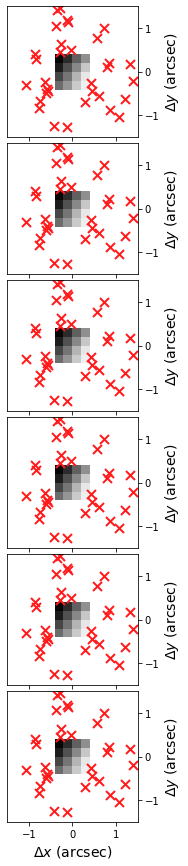

In [446]:
#now plot the crowding
if (worker.EB.crowding.clusterSingles is not None):
    fig,ax = plt.subplots(6,1, figsize=(5, 15), sharex = True)
    for i,f in enumerate(worker.filters):
        vmax = np.max(worker.EB.crowding.fluxgrid[f])
        vmin = np.min(worker.EB.crowding.fluxgrid[f])
        cmp = ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f], cmap='Greys_r', vmin=vmin, vmax=vmax)#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        #ax[i].set_title(f)
        ax[i].plot(worker.EB.crowding.clusterSingles['xAng'], 
                      worker.EB.crowding.clusterSingles['yAng'], 
                   'x', color='#FF1B1C',markeredgewidth=2, markersize=9, alpha=1)
        ax[i].set_ylabel(r'$\Delta y$ (arcsec)', fontsize=14)
        ax[i].yaxis.set_ticks_position('right')
        ax[i].yaxis.set_label_position('right')
        ax[i].set_xlim(-1.5, 1.5)
        ax[i].set_ylim(-1.5, 1.5)
        ax[i].set_yticks([-1,0,1])
    ax[5].set_xlabel(r'$\Delta x$ (arcsec)', fontsize=14)
    plt.subplots_adjust(hspace=0.05)
    
    # Now adding the colorbar
#     cbaxes = fig.add_axes([0.92, 0.33, 0.01, 0.32]) 
#     cbar = plt.colorbar(cmp, cax = cbaxes) 
#     cbaxes.set_ylabel('Flux')

    fig.savefig('M10crowding_pixels.pdf', format = 'pdf', bbox_inches = 'tight')



In [394]:
if (worker.EB.crowding.galaxySingles is not None):
    f,ax = plt.subplots(1,6, figsize=(15, 5))
    for i,f in enumerate(worker.filters):
        ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f])#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.galaxySingles['xAng'], 
                      worker.EB.crowding.galaxySingles['yAng'], s=3, color='white')

In [395]:
print(worker.EB.light_3)

{'u_': <Quantity 0.7006131>, 'g_': <Quantity 0.34274864>, 'r_': <Quantity 0.27281172>, 'i_': <Quantity 0.25828973>, 'z_': <Quantity 0.26045932>, 'y_': <Quantity 0.26683598>}


In [396]:
#also check the light curve
worker.EB.useOpSimDates = True
worker.run_ellc()
appMagObs = worker.EB.appMagObs.copy()
appMag = worker.EB.appMag.copy()
obsDates = worker.EB.obsDates.copy()

#and check with no light_3 as a comparison
light_3 = {}
for f in worker.filters:
    light_3[f] = 0.
worker.run_ellc(light_3 = light_3)
appMagObs_noLight3 = worker.EB.appMagObs.copy()
appMag_noLight3 = worker.EB.appMag.copy()

In [397]:
#also try to get a clean light curve with very find sampling
worker.EB.useOpSimDates = False
worker.EB.cadence = 0.1

worker.run_ellc()
appMagObs_full = worker.EB.appMagObs.copy()
appMag_full = worker.EB.appMag.copy()
obsDates_full = worker.EB.obsDates.copy()

worker.run_ellc(light_3 = light_3)
appMagObs_noLight3_full = worker.EB.appMagObs.copy()
appMag_noLight3_full = worker.EB.appMag.copy()
obsDates_noLight3_full = worker.EB.obsDates.copy()


In [398]:
#to reproduce the plot!
#worker = pickle.load( open( "worker_save.pickle", "rb" ) )
#obsDates = pickle.load( open( "obsDates_save.pickle", "rb" ) )
#to reproduce the plot!
pickle.dump(obsDates, open( "obsDates_save.pickle", "wb" ) )

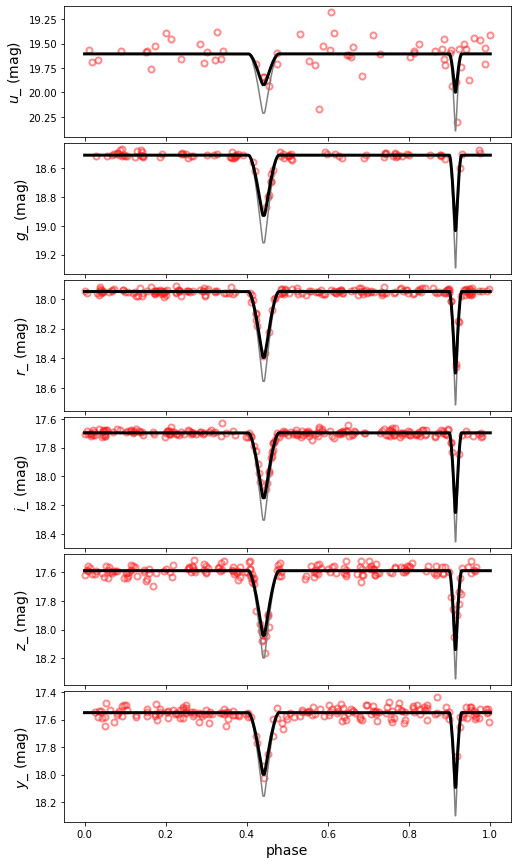

In [399]:
fig,ax = plt.subplots(6,1, figsize=(8,15), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (obsDates[f] % worker.EB.period)/worker.EB.period
    #ax[i].plot(phase, appMag[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    #ax[i].plot(phase, appMag_noLight3[f],'o', color='red', mew=2, mfc='none')
    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')
    
    ax[i].plot(phase, appMagObs[f],'o', markeredgecolor='#FF1B1C',markeredgewidth=2, markerfacecolor="None", 
               markersize=6, alpha=0.5)

    phase_noLight3_full = (obsDates_noLight3_full[f] % worker.EB.period)/worker.EB.period
    s = np.argsort(phase_noLight3_full)
    ax[i].plot(phase_noLight3_full[s], appMag_noLight3_full[f][s], color='gray', lw=1.5)

    phase_full = (obsDates_full[f] % worker.EB.period)/worker.EB.period
    s = np.argsort(phase_full)
    ax[i].plot(phase_full[s], appMag_full[f][s], color='black', lw=3)



    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(r'$'+str(f[0])+'\_$ (mag)', fontsize=14)
ax[5].set_xlabel('phase',fontsize=14)
plt.subplots_adjust(hspace=0.05)
fig.savefig('M10crowding_LC.pdf', format = 'pdf', bbox_inches = 'tight')


In [350]:
# fig,ax = plt.subplots(6,1, figsize=(10,10), sharex = True)
# for i,f in enumerate(worker.filters):
#     #with crowding
#     phase = (worker.EB.obsDates[f] % worker.EB.period)/worker.EB.period
#     ax[i].plot(phase, appMag[f] - appMag_noLight3[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
#     ax[i].plot(phase, appMagObs[f] - appMagObs_noLight3[f],'o', color='green')

#     #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')

#     ax[i].set_ylim(ax[i].get_ylim()[::-1])
#     ax[i].set_ylabel(f)

# plt.subplots_adjust(hspace=0)